In [1]:
import gzip, json, re
from collections import defaultdict, Counter
from os import listdir
import sys
import pylab as plt
import matplotlib.cm as cm
import numpy as np
import random
from datetime import datetime
import statsmodels.api as sm
import time
from copy import deepcopy
from itertools import groupby
import itertools
import networkx as nx
from sklearn import manifold
import gensim
from scipy import spatial
import matplotlib as mpl
import torch
import torch.nn as nn
import torch.optim
from torch.autograd import Variable
import operator
%matplotlib inline

def flushPrint(www):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % www)
    sys.stdout.flush()


/Users/lingfeiw/anaconda/lib/python2.7/site-packages/cryptography/hazmat/primitives/constant_time.py:26: CryptographyDeprecationWarning: Support for your Python version is deprecated. The next version of cryptography will remove support. Please upgrade to a 2.7.x release that supports hmac.compare_digest as soon as possible.
  utils.DeprecatedIn23,


# Data preparation

### 1. Identify core members

In [2]:
# learn team members from contribution data

W=defaultdict(lambda:defaultdict(lambda:0))#n of contributions
#X=defaultdict(lambda:defaultdict(lambda:0))#last contributing time
#N={}
n=0
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/PushEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)#138
        line= line.strip().split(',')
        if len(line)==3:
            actor,repo,date=line
        if len(line)==5:
            actor,repo,date,pushSize,realSize=line
        actor=int(actor)
        repo=int(repo)
        date=date[:10]
        W[repo][actor]+=1
        #if date>X[repo][actor]:
            #X[repo][actor]=date

138

In [5]:
W[1]

defaultdict(<function __main__.<lambda>>,
            {1: 1,
             20418: 154,
             30640: 4,
             31238: 988,
             33410: 49,
             48532: 50,
             103713: 1,
             122610: 317,
             135309: 7,
             229515: 1,
             697351: 32,
             728748: 7})

In [3]:
# identify core contributors, sorted by contribution
C={}
n=0
for i in W:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)#9
    if len(W[i])>=2:
        ms=np.mean(W[i].values())
        sorted_x = sorted(W[i].items(), key=operator.itemgetter(1),reverse=True)
        #C[i]=[k for k,v in W[i].items() if v>=ms]
        C[i]=[k for k,v in sorted_x if v>ms]

9

In [6]:
C[1]

[31238, 122610, 20418]

In [4]:
len(C)

709490

### 2. Construct (programming language) skill vectors of users

In [7]:
# calculate project popularity
U={}
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/CreateEvent.csv', "rb") as f:
    for line in f:
        actor,repo,date=line.strip().split(',')
        repo=int(repo)
        U[repo]=int(actor)
        
n=0
P=defaultdict(lambda:0)
with open('/Users/lingfeiw/Documents/bigdata/Github_Small/ForkEvent.csv', "rb") as f:
    for line in f:
        n+=1
        if n%1000000==0:
            flushPrint(n/1000000)#9
        line= line.strip().split(',')
        actor,repo,date=line
        repo=int(repo)
        if repo in U and actor!=U[repo]:#remove self citation 
# more systematica way to remove self-citation: 
# by contributors and not creators# from Xiaoshuang 2019-1-18 Nanjing U
            P[repo]+=1
P=dict(P)

9

In [10]:
P[1]

148

In [9]:
len(P),len([i for i in P if P[i]>=3]),len([i for i in P if P[i]>=3])/float(len(P))

(1226161, 343892, 0.28046235363871463)

In [11]:
# project language
L={}
f = open('/Users/lingfeiw/Documents/bigdata/Github_Small/Repo_final.txt', "rb")
for line in f:
    repoID, repoName, language, teamSize, NofPushes, repoFinalSize = line.strip().split('\t')
    if language!='0':
        L[int(repoID)]=language

In [12]:
len(L)

7672872

In [13]:
L[1]

'Ruby'

In [14]:
# successful rate
n=0
S=defaultdict(lambda:defaultdict(lambda:[0,0]))# total contributed projects, successful contributed projects, 
for i in C:
    n+=1
    if n%1000000==0:
        flushPrint(n/1000000)#9
    if i in L and L[i]!='0':
        users=C[i]
        lan=L[i]
        for u in users:
            S[u][lan][0]+=1
        if i in P:#ever cited
            for u in users:
                S[u][lan][1]+=1
S=dict(S)# freeze
for i in S.keys():
    S[i]=dict(S[i])

In [19]:
S[101]

{'CSS': [1, 0],
 'Go': [7, 5],
 'JavaScript': [3, 2],
 'Python': [19, 11],
 'Ruby': [2, 0],
 'Shell': [1, 1]}

In [15]:
len(S)

322717

In [20]:
Z=defaultdict(lambda:0)
for i in L:
    Z[L[i]]+=1
lans=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k)))[0]
top20lans=zip(*sorted(Z.iteritems(), key=lambda (k,v): (-v,k)))[0][:20]

In [21]:
len(lans)

218

In [79]:
# population mean successful rate
n=0
LS=defaultdict(lambda:[])
for u in S:
    n+=1
    if n%10000==0:
        flushPrint(n/10000)#32
    for i in top20lans:
        if i in S[u]:
            a,b=map(float,S[u][i])
            r=b/a
            LS[i].append(r)

32

In [91]:
PR=dict((k,np.mean(v)) for k,v in LS.items())
PR

{'C': 0.44290848064382504,
 'C#': 0.34561618788945553,
 'C++': 0.42564912964476731,
 'CSS': 0.32771934973442179,
 'Clojure': 0.48141055300808461,
 'CoffeeScript': 0.46174381895683608,
 'Emacs Lisp': 0.53143430489863464,
 'Go': 0.49960413555276195,
 'Haskell': 0.43622346664938816,
 'Java': 0.36429033146748696,
 'JavaScript': 0.4059216269275836,
 'Objective-C': 0.36375356632901568,
 'PHP': 0.38679615955339325,
 'Perl': 0.52667961136414754,
 'Python': 0.45352566016546036,
 'R': 0.44230762211644559,
 'Ruby': 0.40029099917367367,
 'Scala': 0.45904354849615769,
 'Shell': 0.48920352202546669,
 'VimL': 0.45477036350530331}

In [80]:
len(S),len(LS)

(322717, 20)

In [84]:
def createSkilVector(sklldic):
    v=[]
    for i in top20lans:
        if i in sklldic:
            a,b=sklldic[i]
            v.append(b/float(a))
        else:
            v.append(0)
    return v

def createSkilVectorP(sklldic):
    v=[]
    for i in top20lans:
        if i in sklldic:
            a,b=sklldic[i]
            r=b/float(a)
            v.append(r/PR[i])
        else:
            v.append(0)
    return v

# Normalized succesfful rate (by population mean) ; by Jianyuan 2019-1-18 Nanjing U

In [90]:
i=5
zip(top20lans,createSkilVector(S[i]),createSkilVectorP(S[i]))

[('JavaScript', 1.0, 2.4635297398884339),
 ('Ruby', 0, 0),
 ('Java', 0, 0),
 ('Python', 1.0, 2.2049469034126288),
 ('PHP', 0, 0),
 ('CSS', 0, 0),
 ('C', 0, 0),
 ('C++', 1.0, 2.349352859794561),
 ('Shell', 0, 0),
 ('Objective-C', 0.5, 1.3745569701102236),
 ('C#', 0, 0),
 ('R', 0, 0),
 ('Perl', 0, 0),
 ('VimL', 0, 0),
 ('Go', 0, 0),
 ('CoffeeScript', 0, 0),
 ('Scala', 0, 0),
 ('Clojure', 0, 0),
 ('Haskell', 0, 0),
 ('Emacs Lisp', 0, 0)]

In [92]:
# project vector
n=0
V={}
for k in P:
    n+=1
    if n%100000==0:
        flushPrint(n/100000)#12
    if k in C:
        team=C[k]
        if len(team)>=2:
            if len([u for u in team if u in S])==len(team):# all users have skill vectors
                vs=[]
                for u in team:
                    sklldic=S[u]
                    vs.append(createSkilVectorP(sklldic))
                V[k]=np.array(vs).T

12

In [93]:
C[1]

[31238, 122610, 20418]

In [94]:
zip(*[top20lans]+zip(*map(list,V[1])))

[('JavaScript', 0.82117657996281135, 0.0, 2.4635297398884339),
 ('Ruby', 1.8951729897030003, 2.1475604612184718, 2.2483643196021958),
 ('Java', 1.8300421643942721, 2.7450632465914082, 0.0),
 ('Python', 0.0, 0.0, 0.0),
 ('PHP', 0.0, 0.0, 0.0),
 ('CSS', 0.0, 0.0, 0.0),
 ('C', 0.0, 0.0, 0.0),
 ('C++', 0.0, 0.0, 0.0),
 ('Shell', 2.0441390034553808, 0.0, 0.0),
 ('Objective-C', 0.0, 0.0, 0.0),
 ('C#', 0.0, 0.0, 0.0),
 ('R', 0.0, 0.0, 0.0),
 ('Perl', 0.0, 0.0, 0.0),
 ('VimL', 0.0, 0.0, 0.0),
 ('Go', 0.0, 0.0, 0.0),
 ('CoffeeScript', 0.0, 0.0, 0.0),
 ('Scala', 0.0, 0.0, 0.0),
 ('Clojure', 0.0, 0.0, 0.0),
 ('Haskell', 0.0, 0.0, 0.0),
 ('Emacs Lisp', 0.0, 0.0, 0.0)]

In [769]:
len([i for i in C if len(C[i])>=2])

9914542

In [95]:
#project label
Y={}
for i in V:
    if P[i]>=3:
        Y[i]=1#success
    else:
        Y[i]=0# fail

In [41]:
Counter(Y.values())

Counter({0: 21144, 1: 26306})

In [42]:
L[1],P[1],Y[1]

('Ruby', 148, 1)

### 3. Toy model

In [96]:
# average skills
V1=dict((k,np.mean(v,axis=1)) for k,v in V.items())# accuracy 63%

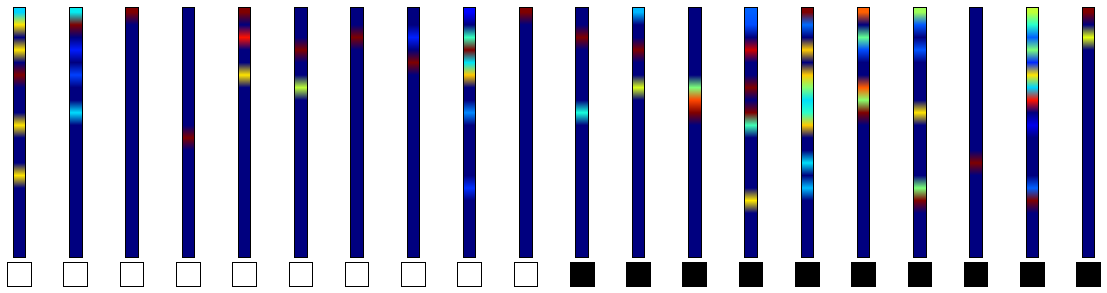

In [716]:
fig = plt.figure(figsize=(20, 5))
s=[7733259,3407887,8388628,7077911,8519705,7602204,4194309,131107,1966117,
 3014698,131077,9,9043981,16,22,4800973,32,786491,4718654,1966149]
for i in range(40):
    if i <20:
        axi = plt.subplot2grid((10, 20), (0, i),rowspan=9)
        axi.imshow([[j] for j in V1[s[i]]])
        axi.set(xticks=[],yticks=[])
    else:
        axi = plt.subplot2grid((10, 20), (9, i-20),rowspan=1)
        axi.imshow([[Y[s[i-20]]]],vmax=1,vmin=0,cmap='binary')
        axi.set(xticks=[],yticks=[])

In [98]:
dataset = V1.values() 
labels = Y.values()

#randomize
indices = np.random.permutation(len(dataset))
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]

#seperate data
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

In [101]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(20, 10),# dim of input layer, dim of hidden layer
    nn.ReLU(),
    nn.Linear(10, 2), #dim of hidden layer, dim of output
    nn.LogSoftmax(),
)

def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [102]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
records = []

#循环10个Epoch
losses = []
for epoch in range(10):
    ls=[]
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，也即第一个为1的维度
        x = Variable(torch.FloatTensor(x).view(1,-1))
        # x的尺寸：batch_size=1, len_dictionary
        # 标签也要加一层外衣以变成1*1的张量
        y = Variable(torch.LongTensor(np.array([y])))
        # y的尺寸：batch_size=1, 1
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        ls.append(loss.data.numpy()[0])
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
    losses.append(np.mean(ls))
    flushPrint(epoch)          

9

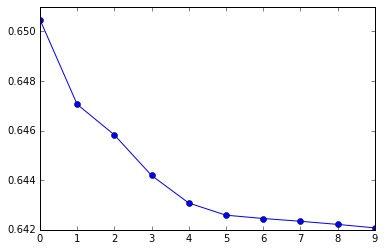

In [103]:
plt.plot(losses ,'bo-')

In [712]:
'''
test_data_=[]
test_label_=[]
a=0
b=0
for data, target in zip(test_data, test_label):
    if target==1:
        a+=1
        test_data_.append(data)
        test_label_.append(target)
'''

In [104]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = Variable(torch.FloatTensor(data).view(1,-1)), Variable(torch.LongTensor(np.array([target])))
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
right_rate

0.6236037934668072

### open the black box

In [723]:
# 将神经网络的架构打印出来，方便后面的访问
model.named_parameters

<bound method Sequential.named_parameters of Sequential(
  (0): Linear(in_features=20, out_features=10)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=2)
  (3): LogSoftmax()
)>

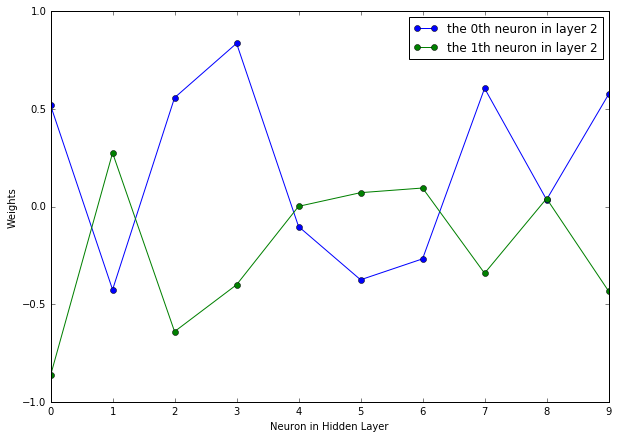

In [724]:
# 绘制出第二个全链接层的权重大小
# model[2]即提取第2层，网络一共4层，第0层为线性神经元，第1层为ReLU，第2层为第二层神经原链接，第3层为logsoftmax
plt.figure(figsize = (10, 7))
for i in range(model[2].weight.size()[0]):
    weights = model[2].weight[i].data.numpy()
    plt.plot(weights, 'o-', label ='the '+ str(i)+'th neuron in layer 2')
plt.legend()
plt.xlabel('Neuron in Hidden Layer')
plt.ylabel('Weights')

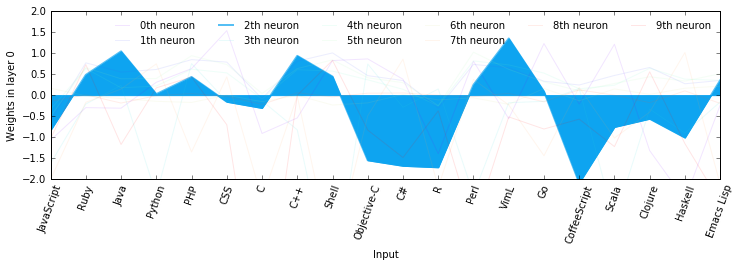

In [728]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
cmap = cm.get_cmap('rainbow',10)
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = fig.add_subplot(111)
for i in range(10):
    weights = model[0].weight[i].data.numpy()
    lw=1
    al=0.1
    if i == 2:
        lw=2
        al=0.7
    plt.plot(weights, linewidth=lw, alpha = al,color=cmap(i), label = str(i)+'th neuron')
    if i == 2:
        plt.fill_between(range(20),weights,0,color=cmap(i))
plt.legend(ncol=6,frameon=False,fontsize=10)
plt.xlabel('Input')
plt.ylabel('Weights in layer 0')
plt.xticks(range(20))
plt.xlim(0,19)
plt.ylim(-2,2)
ax.set_xticklabels(top20lans,rotation=70)
plt.show()

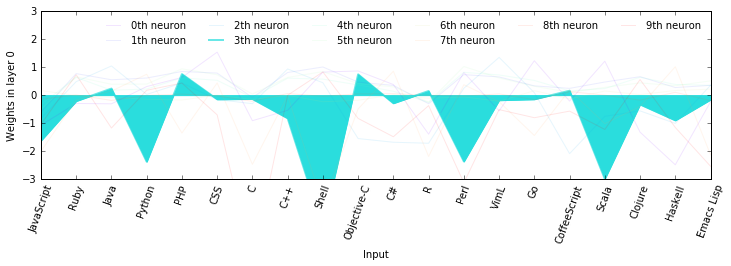

In [731]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
cmap = cm.get_cmap('rainbow',10)
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = fig.add_subplot(111)
for i in range(10):
    weights = model[0].weight[i].data.numpy()
    lw=1
    al=0.1
    if i == 3:
        lw=2
        al=0.7
    plt.plot(weights, linewidth=lw, alpha = al,color=cmap(i), label = str(i)+'th neuron')
    if i == 3:
        plt.fill_between(range(20),weights,0,color=cmap(i))
plt.legend(ncol=6,frameon=False,fontsize=10)
plt.xlabel('Input')
plt.ylabel('Weights in layer 0')
plt.xticks(range(20))
plt.xlim(0,19)
plt.ylim(-3,3)
ax.set_xticklabels(top20lans,rotation=70)
plt.show()

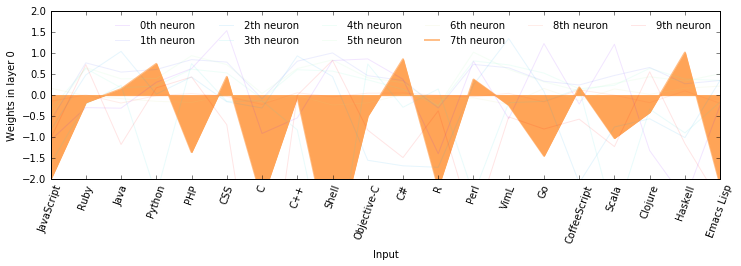

In [732]:
# 将第一层神经元的权重都打印出来，一条曲线表示一个隐含层神经元。横坐标为输入层神经元编号，纵坐标为权重值大小
cmap = cm.get_cmap('rainbow',10)
fig = plt.figure(figsize=(12, 3),facecolor='white')
ax = fig.add_subplot(111)
for i in range(10):
    weights = model[0].weight[i].data.numpy()
    lw=1
    al=0.1
    if i == 7:
        lw=2
        al=0.7
    plt.plot(weights, linewidth=lw, alpha = al,color=cmap(i), label = str(i)+'th neuron')
    if i == 7:
        plt.fill_between(range(20),weights,0,color=cmap(i))
plt.legend(ncol=6,frameon=False,fontsize=10)
plt.xlabel('Input')
plt.ylabel('Weights in layer 0')
plt.xticks(range(20))
plt.xlim(0,19)
plt.ylim(-2,2)
ax.set_xticklabels(top20lans,rotation=70)
plt.show()

In [741]:
#for i in range(len(model[0].weight)):
for i in [2,3,7]:
    #print('\n')
    print('the{}th neuron'.format(i))
    st = sorted([(w,i,top20lans[i]) for i,w in enumerate(model[0].weight[i].data.numpy())])
    print('min',[j for _,_,j in st[:3]],'max',[j for _,_,j in st[-3:]])

the2th neuron
('min', ['CoffeeScript', 'R', 'C#'], 'max', ['C++', 'Java', 'VimL'])
the3th neuron
('min', ['Shell', 'Scala', 'Python'], 'max', ['Java', 'Objective-C', 'PHP'])
the7th neuron
('min', ['Shell', 'C', 'R'], 'max', ['Python', 'C#', 'Haskell'])
